In [1]:
import math
import os
import warnings

import cv2
import numpy
import numpy as np
import scipy
import scipy.fftpack

import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from src.estimate_watermark import *
from src.watermark_reconstruct import *

In [3]:
FOLDERNAME = './images/fotolia_processed'

assert os.path.exists(FOLDERNAME), "Folder does not exist."

images = []
for r, dirs, files in os.walk(FOLDERNAME):
    # Get all the images
    for file in files:
        img = cv2.imread(os.sep.join([r, file]))
        if img is not None:
            images.append(img)
        else:
            print("%s not found." % (file))
images = np.array(images)
images.shape

(127, 500, 500, 3)

# 3.1 Initial Watermark Estimation & Detection

Computing gradients.
Computing median gradients.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


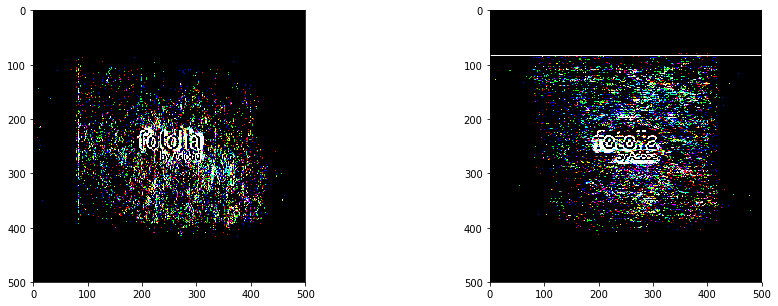

In [4]:
gx, gy = estimate_watermark(images)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(gx)
ax[1].imshow(gy)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


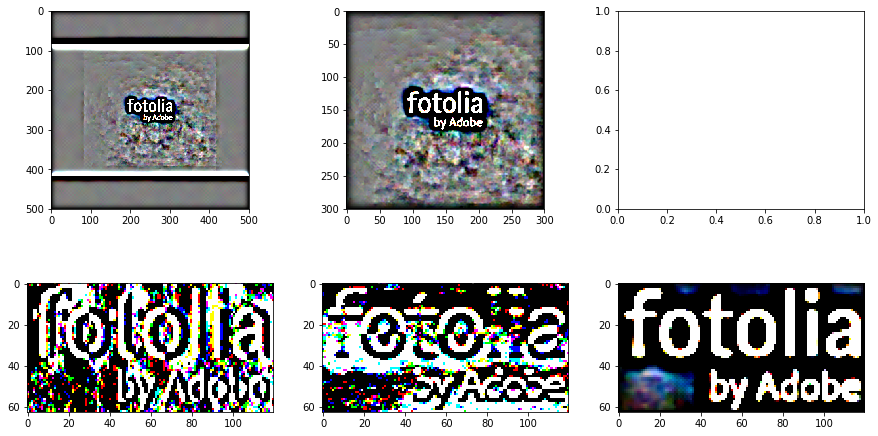

In [5]:
est = poisson_reconstruct(gx, gy)

gx_manual_crop = gx[100:400, 100:400]
gy_manual_crop = gy[100:400, 100:400]
est_manual_crop = poisson_reconstruct(gx_manual_crop, gy_manual_crop)

cropped_gx, cropped_gy = crop_watermark(gx_manual_crop, gy_manual_crop)
est_auto_crop = poisson_reconstruct(cropped_gx, cropped_gy)

fig, ax = plt.subplots(2, 3, figsize=(15, 8))
ax[0][0].imshow(est)
ax[0][1].imshow(est_manual_crop)
ax[1][0].imshow(cropped_gx)
ax[1][1].imshow(cropped_gy)
ax[1][2].imshow(est_auto_crop)

In [6]:
with open('cropped.npz', 'wb') as f:
    np.savez(f, cropped_gx=cropped_gx, cropped_gy=cropped_gy)

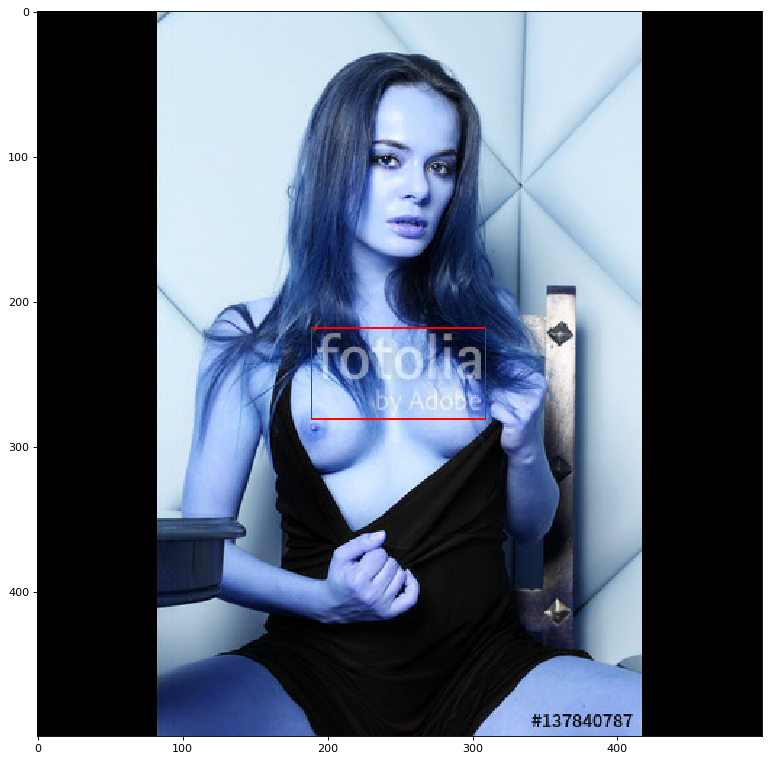

In [7]:
img = cv2.imread('images/fotolia_processed/fotolia_137840787.jpg')
start, rect = watermark_detector(img, cropped_gx, cropped_gy)

im = img.copy()
cv2.rectangle(im, (start[1], start[0]), (start[1] + rect[1], start[0] + rect[0]), (255, 0, 0))

plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(im)
plt.show()

# plt.imshow(im[start[0]:start[0] + rect[0], start[1]:start[1] + rect[1]])
# plt.show()

In [8]:
start, rect

((218, 189), (63, 120))

# 3.2 Multi-Image Matting and Reconstruction

In [9]:
images_cropped = images[:, start[0]:start[0] + rect[0], start[1]:start[1] + rect[1]]

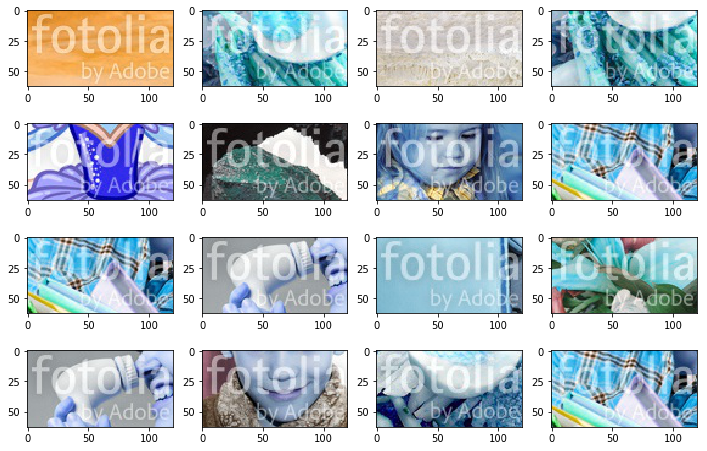

In [10]:
# Print some random indices extracted
N = 4
random_indices = np.random.randint(images_cropped.shape[0], size=(N*N,))
fig, axes = plt.subplots(N, N, figsize=(12, 8))
for i, val in enumerate(random_indices):
    axes[i//N, i%N].imshow(images_cropped[val])

In [ ]:
J = images_cropped
W_m = est_auto_crop

# Wm = (255*PlotImage(W_m))
Wm = W_m - W_m.min()

# get threshold of W_m for alpha matte estimate
alph_est = estimate_normalized_alpha(J, Wm)
alph = np.stack([alph_est, alph_est, alph_est], axis=2)
C, est_Ik = estimate_blend_factor(J, Wm, alph)

alpha = alph.copy()
for i in range(3):
    alpha[:, :, i] = C[i] * alpha[:, :, i]

Wm = Wm + alpha * est_Ik

W = Wm.copy()
for i in range(3):
    W[:, :, i] /= C[i]

------------------------------------
Iteration: 0
Step 1


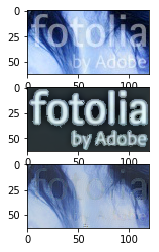

0
Step 2


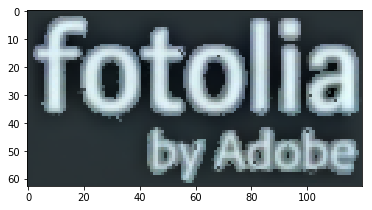

Step 3


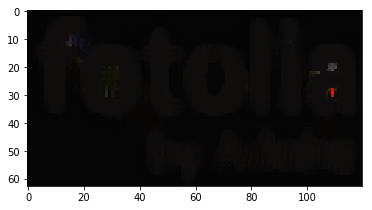

------------------------------------
Iteration: 1
Step 1


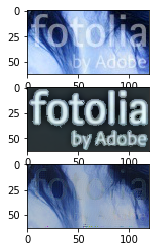

0
Step 2


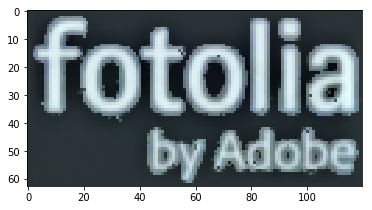

Step 3


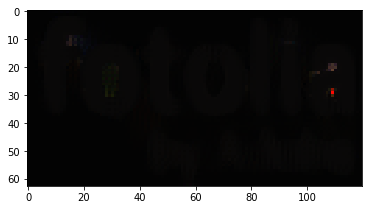

------------------------------------
Iteration: 2
Step 1


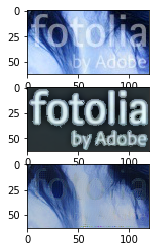

0
Step 2


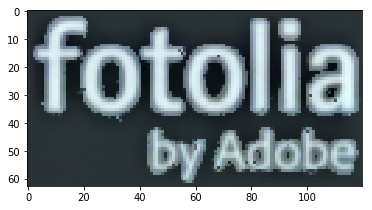

Step 3


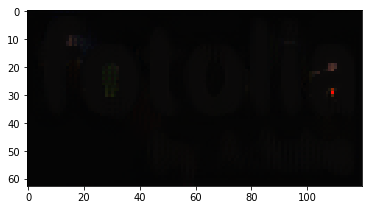

------------------------------------
Iteration: 3
Step 1


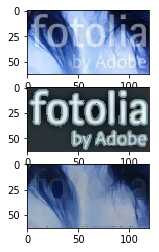

0
Step 2


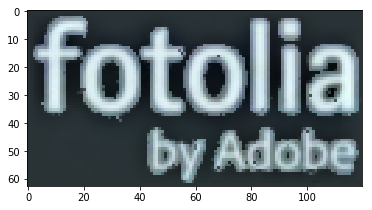

Step 3


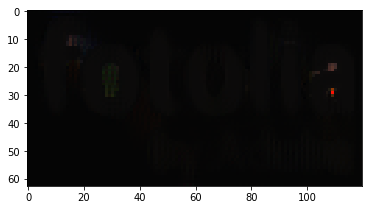

In [16]:
img = cv2.imread('images/fotolia_processed/fotolia_137840787.jpg')[None]
Jt = img[:, start[0]:start[0] + rect[0], start[1]:start[1] + rect[1]]


# now we have the values of alpha, Wm, J
# Solve for all images
Wk, Ik, W, alpha1 = solve_images(Jt, W_m, alpha, W)
# W_m_threshold = (255*PlotImage(np.average(W_m, axis=2))).astype(np.uint8)
# ret, thr = cv2.threshold(W_m_threshold, 127, 255, cv2.THRESH_BINARY)

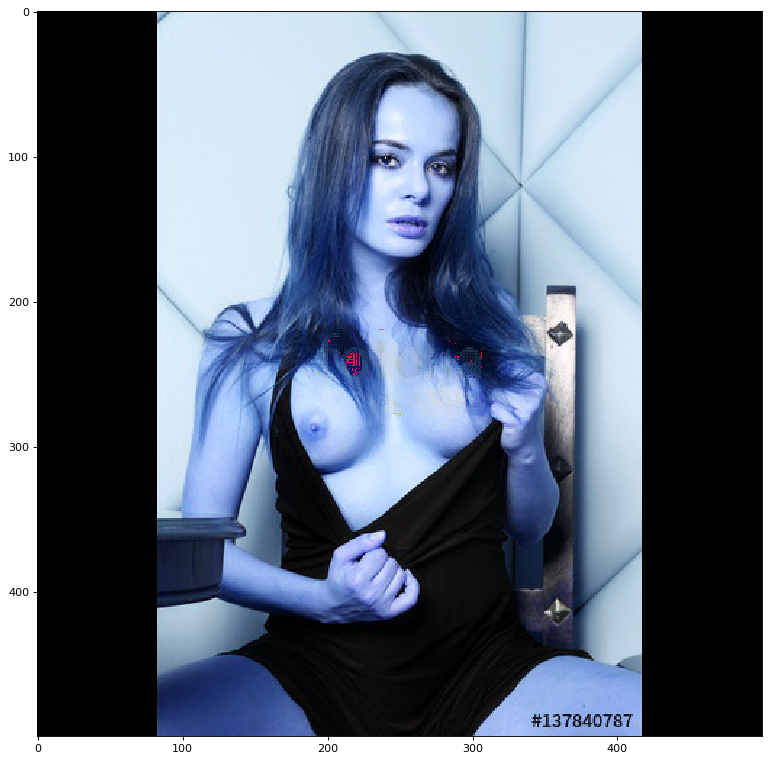

In [24]:
img[:, start[0] + 2: start[0] + rect[0] - 2, start[1] + 2: start[1] + rect[1] - 2] = Ik[:, 2:-2, 2:-2]
img = img.astype(np.uint8)

plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(img[0])
plt.show()